In [34]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter


In [4]:
FILE_PATH = '/Users/laasy/Downloads/complaints.csv'

TARGET_CATEGORY_MAP = {
    'Credit reporting, repair, or other': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}

PRODUCT_COLUMN = 'Product'
NARRATIVE_COLUMN = 'Consumer complaint narrative'


In [5]:
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("Downloading NLTK resources...")
    nltk.download('stopwords')
    nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/laasy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/laasy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'x{2,}', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words and len(word) > 1]
    return ' '.join(tokens)


In [7]:
df = pd.read_csv(FILE_PATH)
df_filtered = df[df[PRODUCT_COLUMN].isin(TARGET_CATEGORY_MAP.keys())].copy()
df_filtered.dropna(subset=[NARRATIVE_COLUMN, PRODUCT_COLUMN], inplace=True)
df_filtered['target_label'] = df_filtered[PRODUCT_COLUMN].map(TARGET_CATEGORY_MAP)
df_filtered.drop_duplicates(subset=[NARRATIVE_COLUMN], inplace=True)

print(f"Filtered dataset size: {len(df_filtered)}")


Filtered dataset size: 459663


In [12]:
df.head(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-07-06,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,346XX,NaN,Other,Web,2020-07-06,Closed with explanation,Yes,NaN,3730948
1,2025-09-24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",KS,67206,NaN,NaN,Web,2025-09-24,In progress,Yes,NaN,16152255
2,2019-12-26,Credit card or prepaid card,General-purpose credit card or charge card,"Advertising and marketing, including promotion...",Confusing or misleading advertising about the ...,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,CA,94025,NaN,Consent not provided,Web,2019-12-26,Closed with explanation,Yes,NaN,3477549
3,2020-05-08,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,These are not my accounts.,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NV,89030,NaN,Consent provided,Web,2020-05-08,Closed with explanation,Yes,NaN,3642453
4,2025-09-23,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,CA,93630,NaN,NaN,Web,2025-09-23,In progress,Yes,NaN,16077048


In [13]:
df.describe()

,Complaint ID
count,1.117088e+07
mean,9.096328e+06
std,4.299913e+06
min,1.000000e+00
25%,5.752398e+06
50%,9.379360e+06
75%,1.265989e+07
max,1.621573e+07


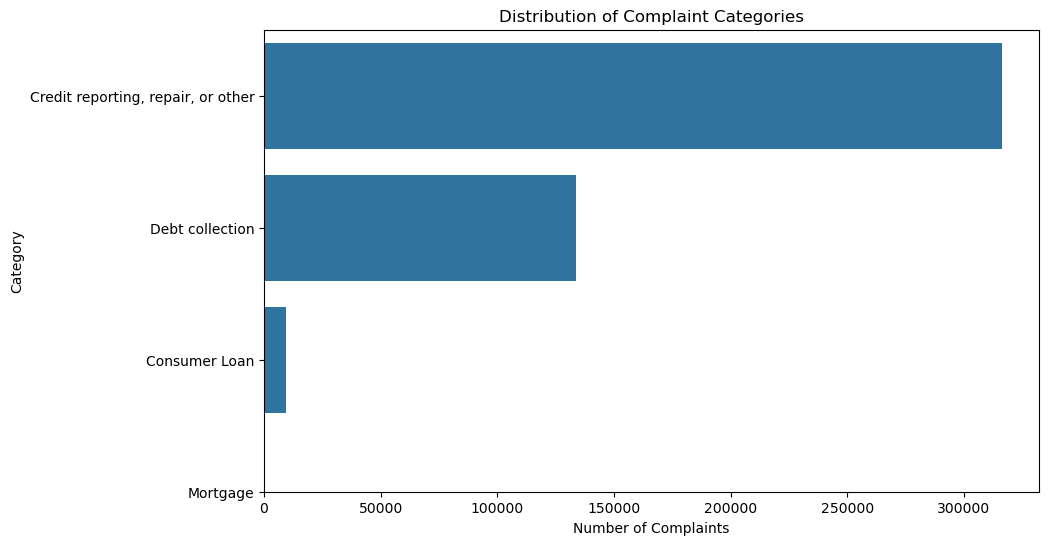

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(y=df_filtered['target_label'], order=df_filtered['target_label'].value_counts().index)
plt.yticks(ticks=list(TARGET_CATEGORY_MAP.values()), labels=list(TARGET_CATEGORY_MAP.keys()))
plt.title('Distribution of Complaint Categories')
plt.xlabel('Number of Complaints')
plt.ylabel('Category')
plt.show()


/var/folders/c0/nzk27tc10h14g5gn56gr9ywh0000gn/T/ipykernel_6614/1113650103.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[label_to_name[i] for i in avg_length.index], y=avg_length.values, palette='coolwarm')


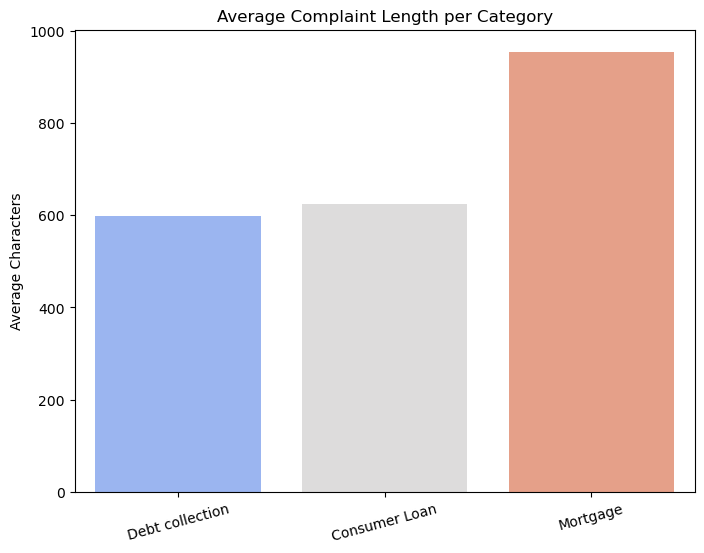

In [23]:
avg_length = df_filtered.groupby('target_label')['processed_narrative'].apply(lambda x: np.mean(x.str.len()))
plt.figure(figsize=(8,6))
sns.barplot(x=[label_to_name[i] for i in avg_length.index], y=avg_length.values, palette='coolwarm')
plt.title('Average Complaint Length per Category')
plt.ylabel('Average Characters')
plt.xticks(rotation=15)
plt.show()

/var/folders/c0/nzk27tc10h14g5gn56gr9ywh0000gn/T/ipykernel_6614/3585930123.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category_name', y='text_length', data=df_filtered, palette='viridis')


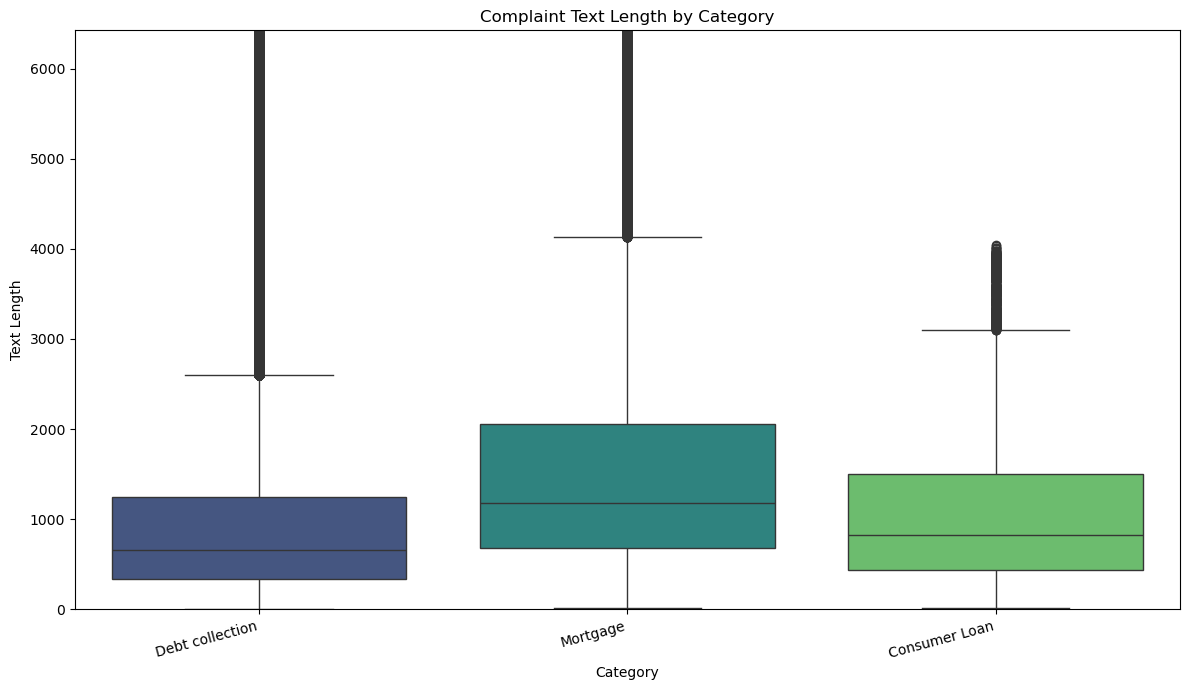

In [39]:
df_filtered['text_length'] = df_filtered[NARRATIVE_COLUMN].apply(lambda x: len(str(x)))
label_to_name = {v: k for k, v in TARGET_CATEGORY_MAP.items()}
df_filtered['category_name'] = df_filtered['target_label'].map(label_to_name)

plt.figure(figsize=(12, 7))
sns.boxplot(x='category_name', y='text_length', data=df_filtered, palette='viridis')
plt.title('Complaint Text Length by Category')
plt.xlabel('Category')
plt.ylabel('Text Length')
plt.xticks(rotation=15, ha='right')
plt.ylim(0, df_filtered['text_length'].quantile(0.99))
plt.tight_layout()
plt.show()

df_filtered.drop(columns=['text_length', 'category_name'], inplace=True, errors='ignore')


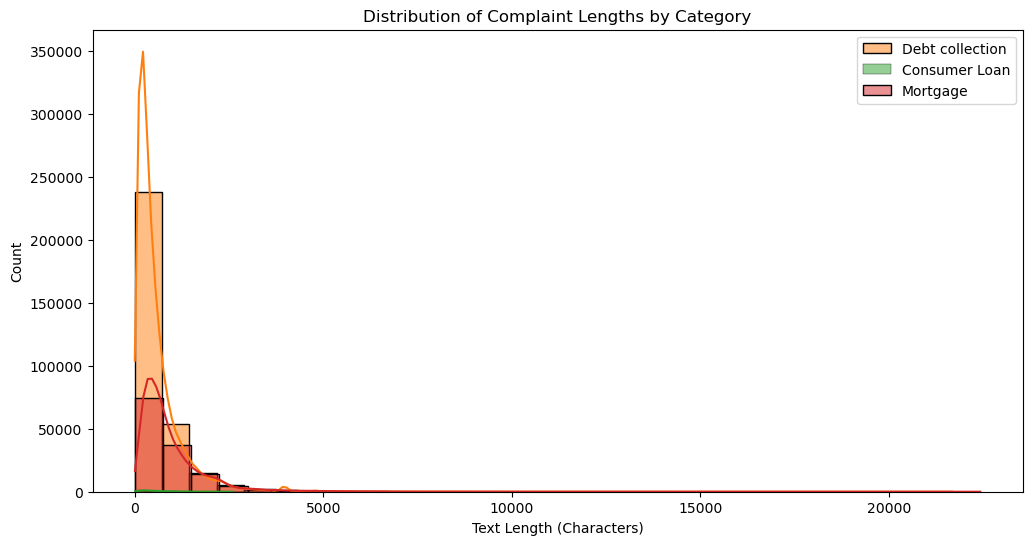

In [25]:
plt.figure(figsize=(12,6))
for label, name in label_to_name.items():
    lengths = df_filtered[df_filtered['target_label']==label]['processed_narrative'].str.len()
    sns.histplot(lengths, bins=30, label=name, kde=True, alpha=0.5)
plt.title('Distribution of Complaint Lengths by Category')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Count')
plt.legend()
plt.show()


No documents found for label: Credit reporting, repair, or other


/var/folders/c0/nzk27tc10h14g5gn56gr9ywh0000gn/T/ipykernel_6614/1825281915.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts, y=top_features, palette='magma')


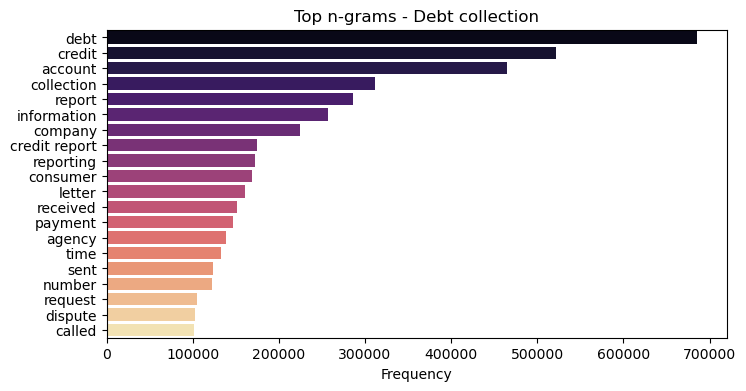

/var/folders/c0/nzk27tc10h14g5gn56gr9ywh0000gn/T/ipykernel_6614/1825281915.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts, y=top_features, palette='magma')


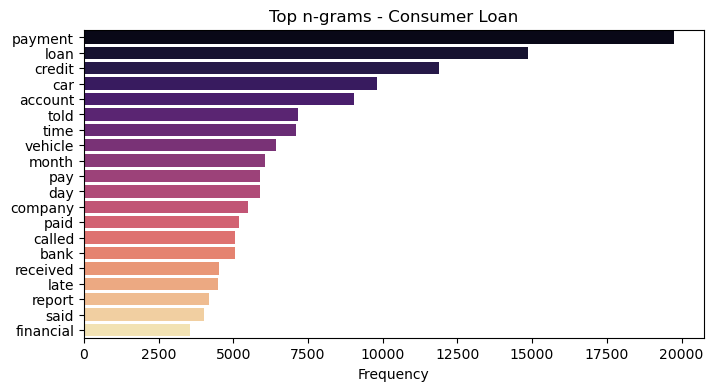

/var/folders/c0/nzk27tc10h14g5gn56gr9ywh0000gn/T/ipykernel_6614/1825281915.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts, y=top_features, palette='magma')


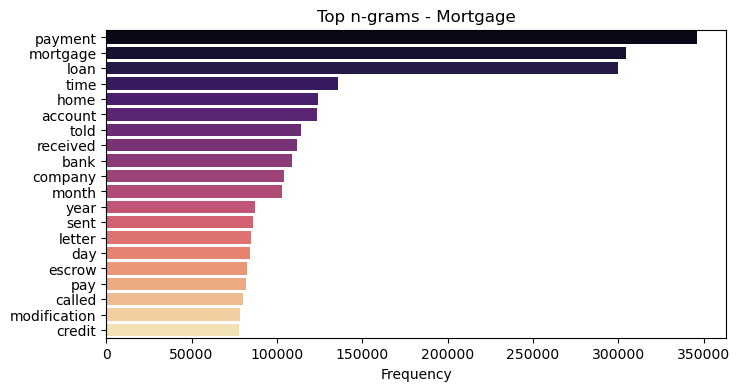

In [40]:
for label, name in label_to_name.items():
    X_cat = df_filtered[df_filtered['target_label']==label]['processed_narrative']
    
    if len(X_cat) == 0:
        print(f"No documents found for label: {name}")
        continue
    
    try:
        vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english', max_features=20)
        X_vec = vectorizer.fit_transform(X_cat)
        
        if len(vectorizer.get_feature_names_out()) == 0:
            vectorizer = CountVectorizer(ngram_range=(1,2), max_features=20)
            X_vec = vectorizer.fit_transform(X_cat)
        
        freqs = np.array(X_vec.sum(axis=0)).flatten()
        indices = np.argsort(freqs)[::-1]
        top_features = [vectorizer.get_feature_names_out()[i] for i in indices]
        top_counts = freqs[indices]
        
        plt.figure(figsize=(8,4))
        sns.barplot(x=top_counts, y=top_features, palette='magma')
        plt.title(f"Top n-grams - {name}")
        plt.xlabel("Frequency")
        plt.show()
    except ValueError as e:
        print(f"Error processing label {name}: {e}")
        # You might want to inspect the data for this label
        print(f"Sample data: {X_cat[:5].tolist()}")

In [42]:
df_filtered['processed_narrative'] = df_filtered[NARRATIVE_COLUMN].apply(preprocess_text)
X = df_filtered['processed_narrative']
y = df_filtered['target_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Train/Test split: {len(X_train)}/{len(X_test)}")

Train/Test split: 344747/114916



Training Logistic Regression...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy = 0.9667


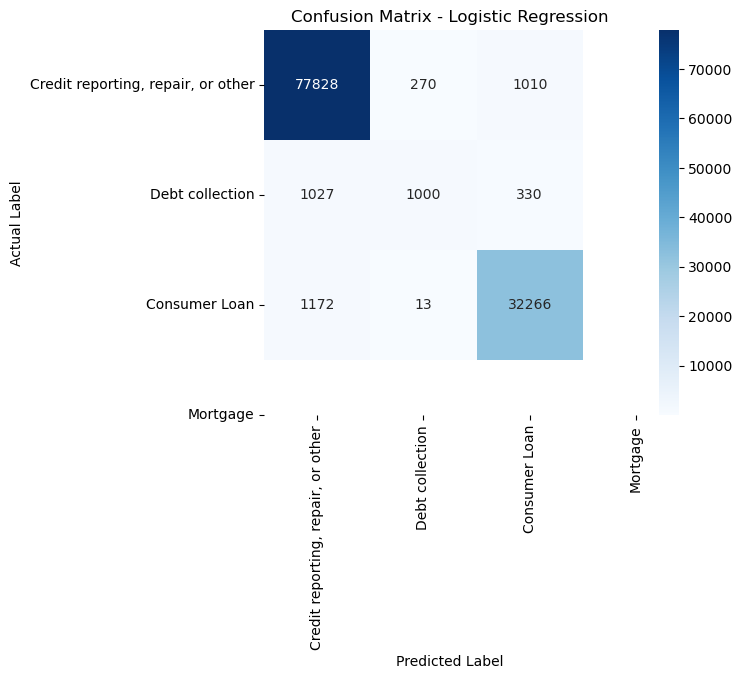


Training Naive Bayes...
Accuracy = 0.9470


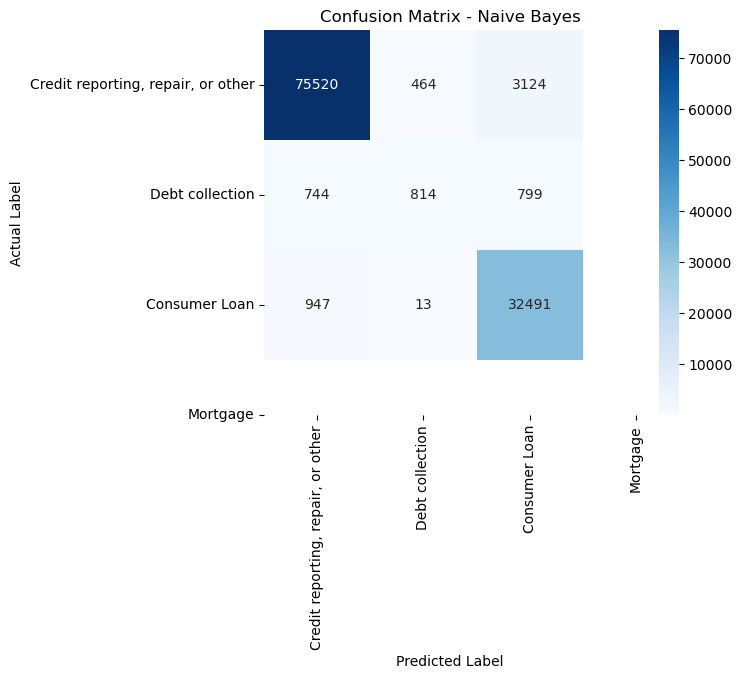


Training Linear SVC...
Accuracy = 0.9668


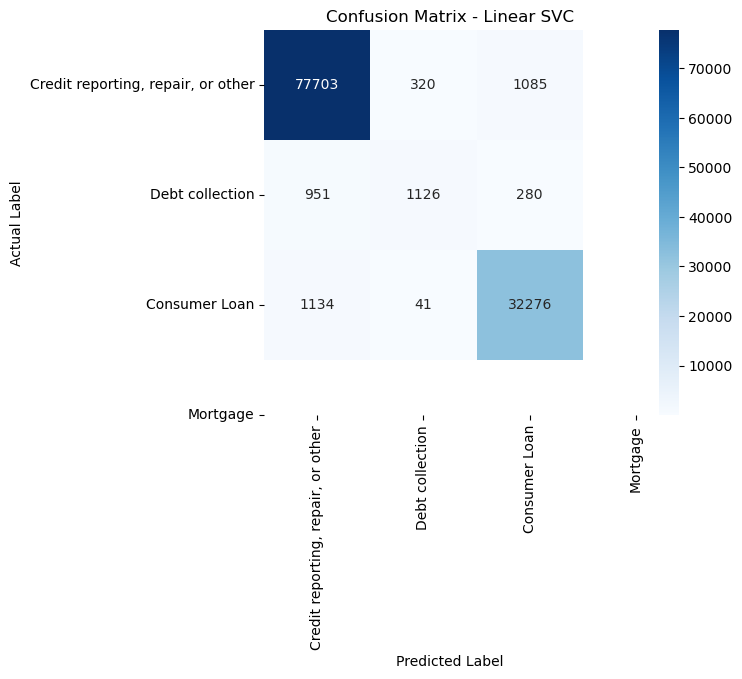

In [38]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr', C=1.0),
    "Naive Bayes": MultinomialNB(),
    "Linear SVC": LinearSVC(random_state=42, C=1.0)
}

results = {}
f1_scores = {}

for name, clf in models.items():
    print(f"\nTraining {name}...")
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=10000)),
        ('clf', clf)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy = {acc:.4f}")
    results[name] = acc

    f1_scores[name] = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[label_to_name[i] for i in range(len(TARGET_CATEGORY_MAP))],
                yticklabels=[label_to_name[i] for i in range(len(TARGET_CATEGORY_MAP))])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()


/var/folders/c0/nzk27tc10h14g5gn56gr9ywh0000gn/T/ipykernel_6614/911452377.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="mako")


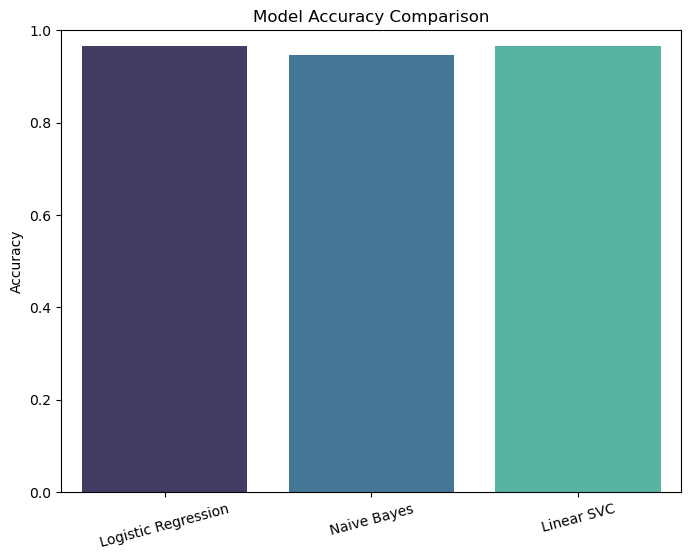

In [43]:
plt.figure(figsize=(8, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="mako")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.show()

/var/folders/c0/nzk27tc10h14g5gn56gr9ywh0000gn/T/ipykernel_6614/2829458341.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(models.keys()), y=f1_macro, palette="viridis")


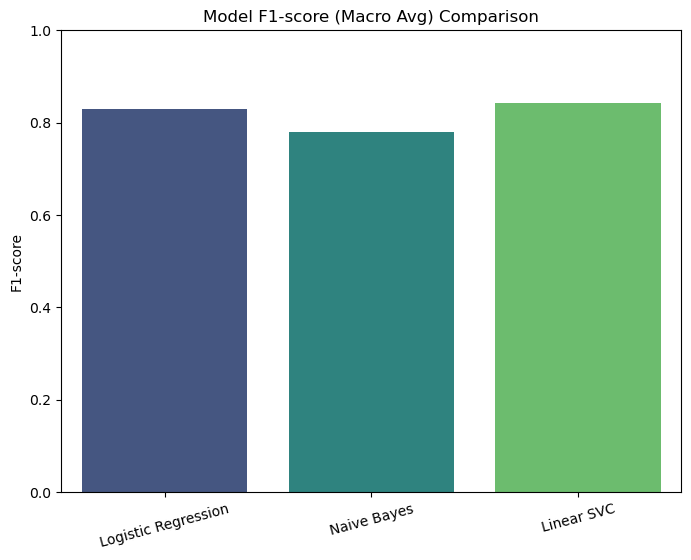

In [44]:
f1_macro = [f1_scores[m]["macro avg"]["f1-score"] for m in models]
plt.figure(figsize=(8, 6))
sns.barplot(x=list(models.keys()), y=f1_macro, palette="viridis")
plt.title("Model F1-score (Macro Avg) Comparison")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.show()

No rows found for Credit reporting, repair, or other (label 0)


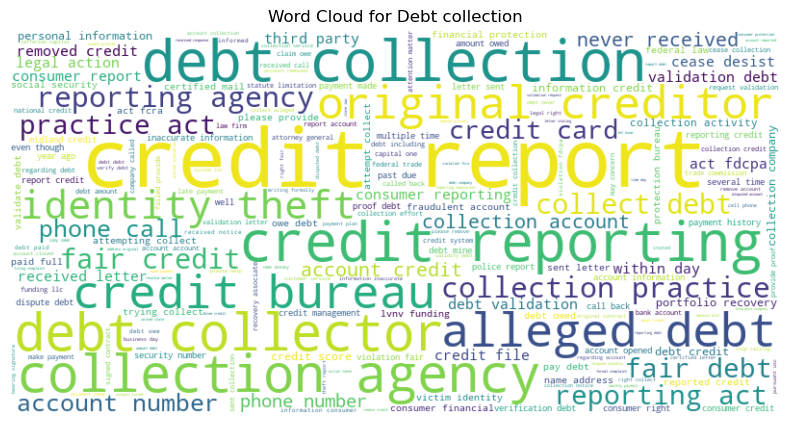

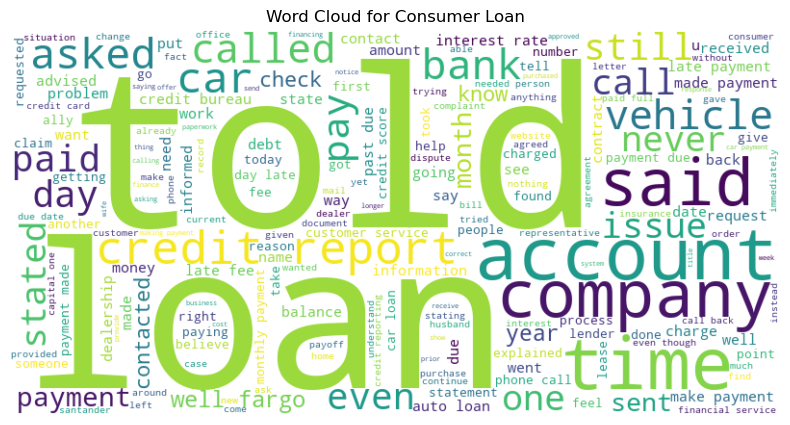

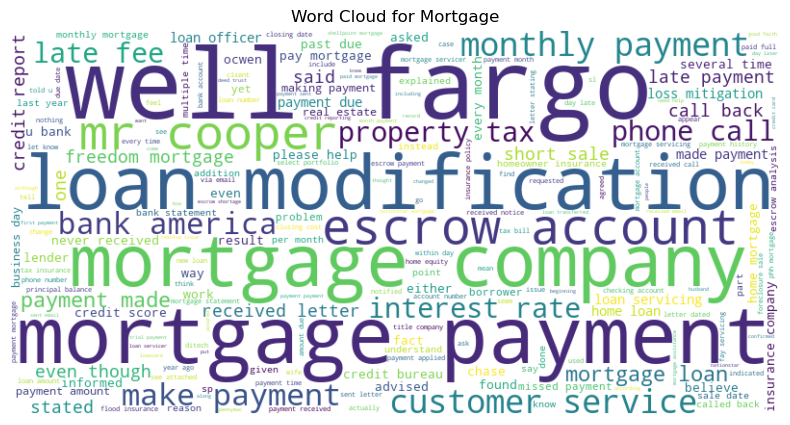

In [28]:
for label, name in label_to_name.items():
    filtered_data = df_filtered[df_filtered["target_label"] == label]
    
    if len(filtered_data) > 0:
        text_data = " ".join(filtered_data["processed_narrative"])
        
        # Check if text_data is not empty
        if text_data.strip():
            wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"Word Cloud for {name}")
            plt.show()
        else:
            print(f"No text data available for {name} (label {label})")
    else:
        print(f"No rows found for {name} (label {label})")

In [29]:
final_model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=10000)),
    ('clf', LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr', C=1.0))
])
final_model.fit(X_train, y_train)

test_complaints = [
    "I have been fighting with a collections agency for six months over a debt that I have already paid off.",
    "My bank is reporting a late payment on my credit file that was made on time."
]

for i, complaint in enumerate(test_complaints, 1):
    processed = preprocess_text(complaint)
    pred_label = final_model.predict([processed])[0]
    pred_category = label_to_name[pred_label]
    print(f"\nTest Complaint {i}: {complaint[:70]}...")
    print(f"Predicted Category: {pred_category} (Label {pred_label})")


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Test Complaint 1: I have been fighting with a collections agency for six months over a d...
Predicted Category: Debt collection (Label 1)

Test Complaint 2: My bank is reporting a late payment on my credit file that was made on...
Predicted Category: Mortgage (Label 3)
